In [1]:

!apt-get update
!apt-get install -y tesseract-ocr
!pip install pytesseract


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,197 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,632 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Fetched 4,225 kB in 2s (2,689 kB/s)
Reading pack

In [3]:
import cv2
import imutils
import numpy as np
from google.colab.patches import cv2_imshow
import pytesseract
import matplotlib as plt

# read and resize image
img = cv2.imread('/content/5b3929415d1_wize16423115PM.jpg', cv2.IMREAD_COLOR)
img = cv2.resize(img, (620, 480))

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.bilateralFilter(gray, 11, 17, 17)

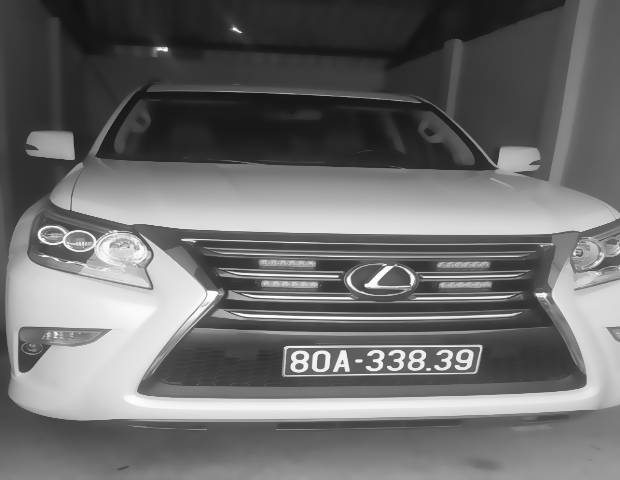

In [5]:
cv2_imshow(gray)

In [8]:
#_, edged = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
edged = cv2.Canny(gray, 30, 200)  # Perform Edge detection

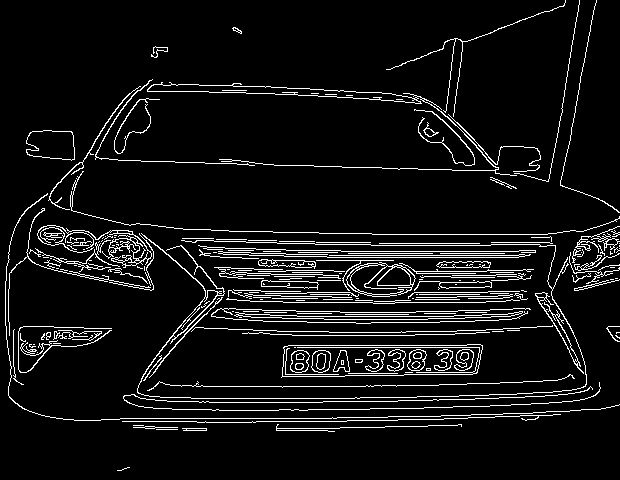

In [9]:
cv2_imshow(edged)

Detected License Plate: 


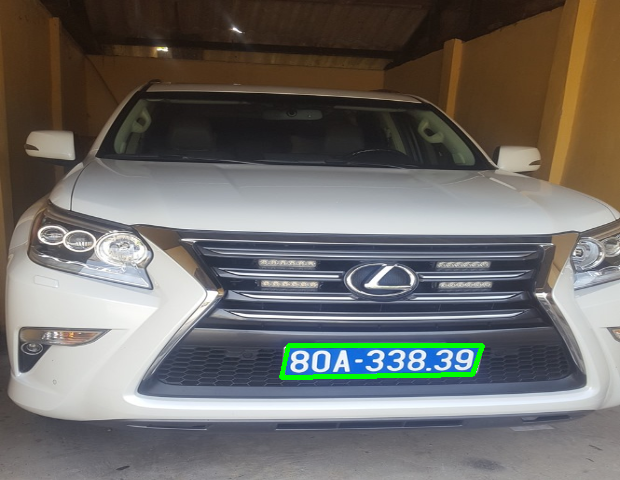

Cropped License Plate: 


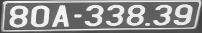

In [10]:
min_size = 100

cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
screenCnt = None

for c in cnts:

    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.05 * peri, True)

    if len(approx) == 4 and cv2.contourArea(c) > min_size:
        screenCnt = approx
        break

if screenCnt is None:
    detected = 0
    print ("No plate detected")
else:
    detected = 1

if detected == 1:
    cv2.drawContours(img, [screenCnt], -1, (0, 255, 0), 3)

    mask = np.zeros(gray.shape, np.uint8)
    new_image = cv2.drawContours(mask, [screenCnt], 0, 255, -1, )
    new_image = cv2.bitwise_and(img, img, mask=mask)

    (x, y) = np.where(mask == 255)
    (topx, topy) = (np.min(x), np.min(y))
    (bottomx, bottomy) = (np.max(x), np.max(y))
    Cropped = gray[topx:bottomx + 1, topy:bottomy + 1]

    print('Detected License Plate: ')
    cv2_imshow(img)
    print("Cropped License Plate: ")
    cv2_imshow(Cropped)

In [11]:
char_list = '0123456789ABCDEFGHKLMNPRSTUVXYZ'

def fine_tune(plate_text):
    return ''.join([char for char in plate_text if char in char_list])

Detected License Plate: 80A33839


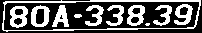

In [12]:
binary_plate = cv2.threshold(Cropped, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
text = pytesseract.image_to_string(binary_plate, config='--psm 7', lang='eng')
detected_plate = fine_tune(text)
print("Detected License Plate:", detected_plate)
cv2_imshow(binary_plate)